In [ ]:
# Mount Google Drive
from google.colab import drive # Import the 'drive' function from the 'google.colab' module
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required libraries
!pip install mediapipe opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import mediapipe as mp
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Model
from keras.layers import Dense, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [ ]:
# Define dataset paths
DATASET_PATHS = {
    "A": "/content/drive/MyDrive/FD/dataset_A",
    "B": "/content/drive/MyDrive/FD/dataset_B",
    "C": "/content/drive/MyDrive/FD/dateset_C",
    "D": "/content/drive/MyDrive/FD/dateset_D"
}

# Initialize Mediapipe face detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

In [ ]:
def load_and_preprocess_data(data_paths, target_size=(224, 224)):
    """Load images, detect faces, and preprocess data."""
    faces, labels = [], []
    for label, path in data_paths.items():
        if not os.path.exists(path):
            print(f"Error: The directory {path} does not exist.")
            continue
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                if img is None:
                    continue
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

                if results.detections:
                    for detection in results.detections:
                        bboxC = detection.location_data.relative_bounding_box
                        ih, iw, _ = img.shape
                        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                        face_image = gray[y:y + h, x:x + w]
                        if face_image.size == 0:
                            continue
                        face_image_resized = cv2.resize(face_image, target_size)
                        faces.append(face_image_resized)
                        labels.append(label)
    return np.array(faces), np.array(labels)

In [ ]:
# Load and preprocess data
faces, labels = load_and_preprocess_data(DATASET_PATHS, target_size=(224, 224))
faces = faces.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(faces, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def convert_to_rgb(images):
    """Convert grayscale images to 3-channel RGB."""
    return np.repeat(images[..., np.newaxis], 3, axis=-1)


X_train_3ch, X_val_3ch, X_test_3ch = map(convert_to_rgb, [X_train, X_val, X_test])
X_train_3ch, X_val_3ch, X_test_3ch = map(preprocess_input, [X_train_3ch, X_val_3ch, X_test_3ch])

In [ ]:
def build_model(input_shape, num_classes):
    """Create a deep learning model based on ResNet50."""
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

In [ ]:
# Initialize and compile the model
model = build_model((224, 224, 3), len(np.unique(y_train)))
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_3ch, y_train, validation_data=(X_val_3ch, y_val), epochs=20, batch_size=32)

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_3ch, y_train)
val_loss, val_accuracy = model.evaluate(X_val_3ch, y_val)
test_loss, test_accuracy = model.evaluate(X_test_3ch, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.2229 - loss: 1.5545 - val_accuracy: 0.2750 - val_loss: 1.3987
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.3053 - loss: 1.3683 - val_accuracy: 0.2000 - val_loss: 1.3656
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.2860 - loss: 1.3522 - val_accuracy: 0.2750 - val_loss: 1.3127
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.2700 - loss: 1.3529 - val_accuracy: 0.6250 - val_loss: 1.2600
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6012 - loss: 1.2930 - val_accuracy: 0.6750 - val_loss: 1.2446
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5495 - loss: 1.2611 - val_accuracy: 0.7750 - val_loss: 1.1895
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6406 - loss: 1.2470 - val_accuracy: 0.3250 - val_loss: 1.2615
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4213 - loss: 1.2344 - val_accuracy: 0.3500 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


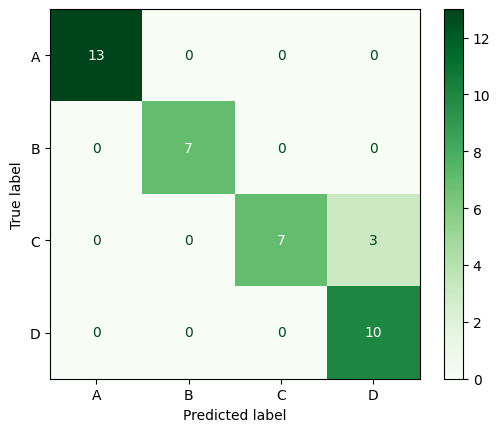

In [ ]:
# Generate confusion matrix
y_pred = np.argmax(model.predict(X_test_3ch), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


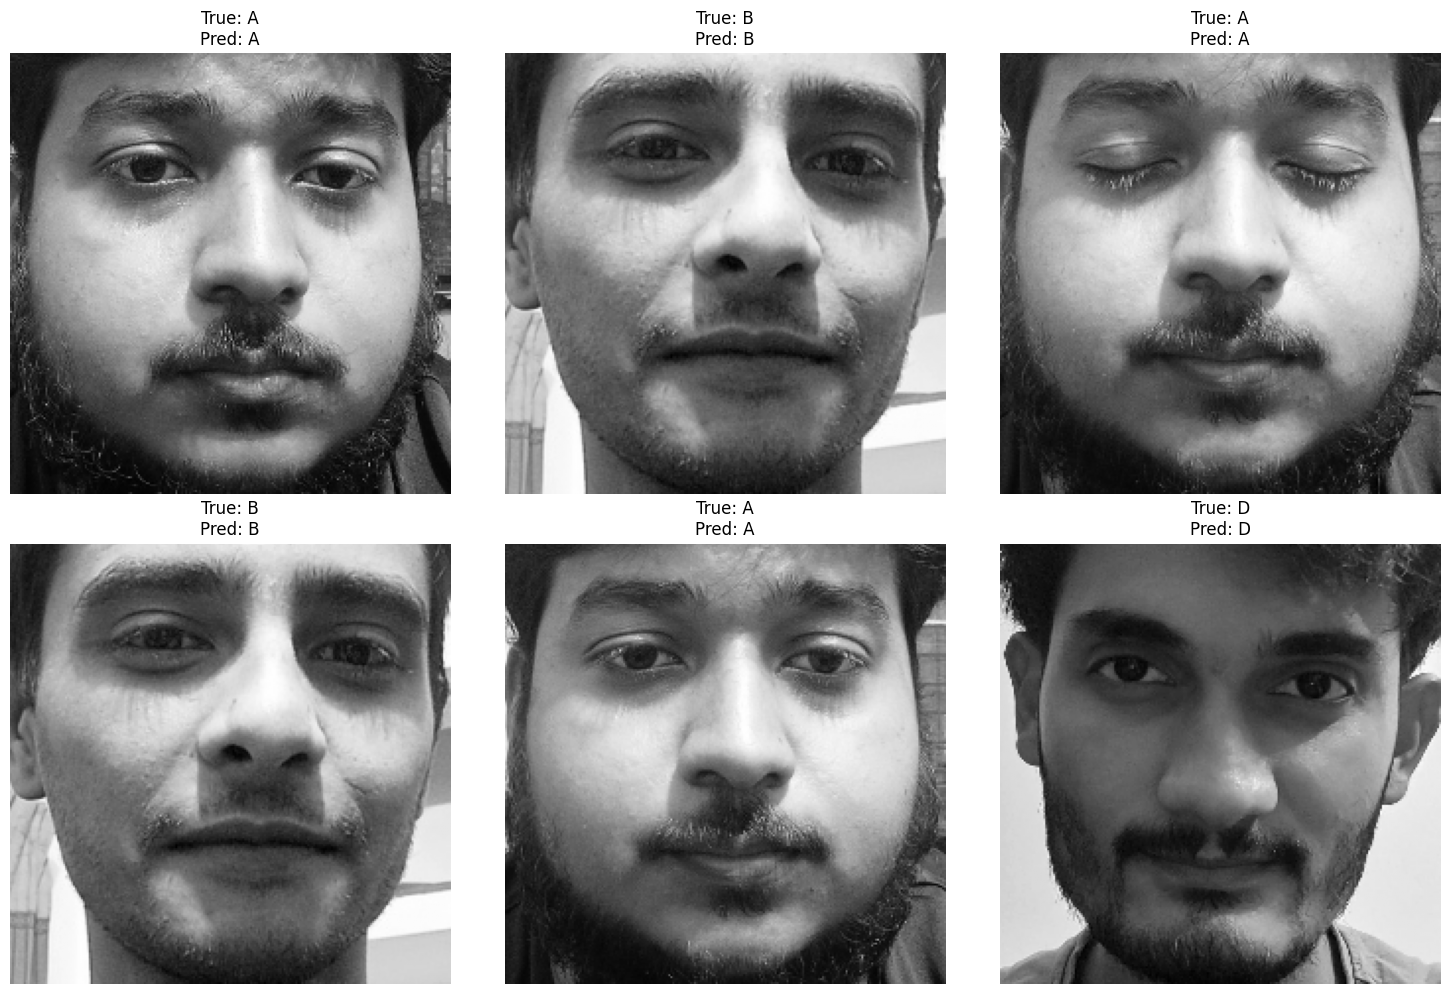

In [ ]:
def display_predictions(X_test, X_test_3ch, y_test, label_encoder, model, num_images=6):
    """Display random test images with true and predicted labels."""
    random_indices = np.random.choice(len(X_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        img_input = np.expand_dims(X_test_3ch[idx], axis=0)
        pred_label = label_encoder.inverse_transform([np.argmax(model.predict(img_input))])[0]
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        plt.subplot(2, 3, i+1)
        plt.imshow(X_test[idx], cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample predictions
display_predictions(X_test, X_test_3ch, y_test, label_encoder, model)